# Imports

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor

# Data loading

In [5]:
df = pd.read_csv(
    r'../files/preprocessed_3_without_DateSinceForSale_HasPhotovoltaics_filled.csv',
    keep_default_na=False,
    na_values=["isNone"]
)

In [7]:
df.head(5)

,Bedrooms,Bathrooms,SquareFootageHouse,Location,Age,PoolQuality,HasPhotovoltaics,HeatingType,HasFiberglass,IsFurnished,...,HasFireplace,KitchensQuality,BathroomsQuality,BedroomsQuality,LivingRoomsQuality,SquareFootageGarden,PreviousOwnerRating,HeatingCosts,Price,WindowMaterial
0,1.0,2.0,127.0,Rural,69.0,Good,False,Electric,True,True,...,False,Good,Good,Good,Good,16.0,1.33,76.243384,346.57594,Wood
1,3.0,3.0,129.0,Rural,65.0,Good,True,Oil,False,False,...,False,Poor,Good,Excellent,Poor,16.0,1.52,206.609811,429.91007,Steel
2,1.0,2.0,99.0,Urban,43.0,Excellent,False,Electric,True,True,...,False,Good,Good,Excellent,Poor,46.0,2.49,59.400000,243.80271,Aluminum
3,2.0,2.0,126.0,Rural,35.0,NoPool,False,Oil,False,False,...,False,Good,Good,Good,Good,6.0,1.44,201.600000,378.22772,Steel
4,1.0,3.0,101.0,Rural,54.0,NoPool,Missing,Electric,False,True,...,False,Excellent,Poor,Poor,Good,6.0,1.88,60.000000,249.67852,Wood


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935 entries, 0 to 934
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Bedrooms             935 non-null    float64
 1   Bathrooms            935 non-null    float64
 2   SquareFootageHouse   935 non-null    float64
 3   Location             935 non-null    object 
 4   Age                  935 non-null    float64
 5   PoolQuality          935 non-null    object 
 6   HasPhotovoltaics     935 non-null    object 
 7   HeatingType          935 non-null    object 
 8   HasFiberglass        935 non-null    bool   
 9   IsFurnished          935 non-null    bool   
 10  HouseColor           935 non-null    object 
 11  HasFireplace         935 non-null    bool   
 12  KitchensQuality      935 non-null    object 
 13  BathroomsQuality     935 non-null    object 
 14  BedroomsQuality      935 non-null    object 
 15  LivingRoomsQuality   935 non-null    obj

In [11]:
X = df.drop('Price', axis=1)
y = df['Price']

# Model loading

In [2]:
model = CatBoostRegressor().load_model('catboost_model.cbm')

In [10]:
cat_features = [
    "Location", "PoolQuality", "HasPhotovoltaics", "HasFireplace", "HouseColor", "HeatingType",
    "HasFiberglass", "IsFurnished", "KitchensQuality", "BathroomsQuality", "BedroomsQuality",
    "LivingRoomsQuality", "WindowMaterial"
]

# Question 1: 'If I have a budget of €100,000, what kind of houses will I be able to buy?'

## Step 1. Predict the prices of the houses in the dataset

In [22]:
predictions = model.predict(X)

In [23]:
df['Predicted_Price'] = predictions

## Step 2. Filter houses within the budget of interest (<= €100,000)

In [19]:
# Identify houses within the budget of €100,000
budget_houses = df[df['Predicted_Price'] <= 100]

In [21]:
# Analyze the features of the houses within the budget
budget_houses_features = budget_houses.drop(columns=['Price', 'Predicted_Price'])

## Step 3. Analyze features

In [24]:
# Separate numerical and categorical columns
numerical_budget_houses_features = budget_houses_features.select_dtypes(include=['float64', 'int']).columns
categorical_budget_houses_features = budget_houses_features.select_dtypes(include=['object', 'bool']).columns

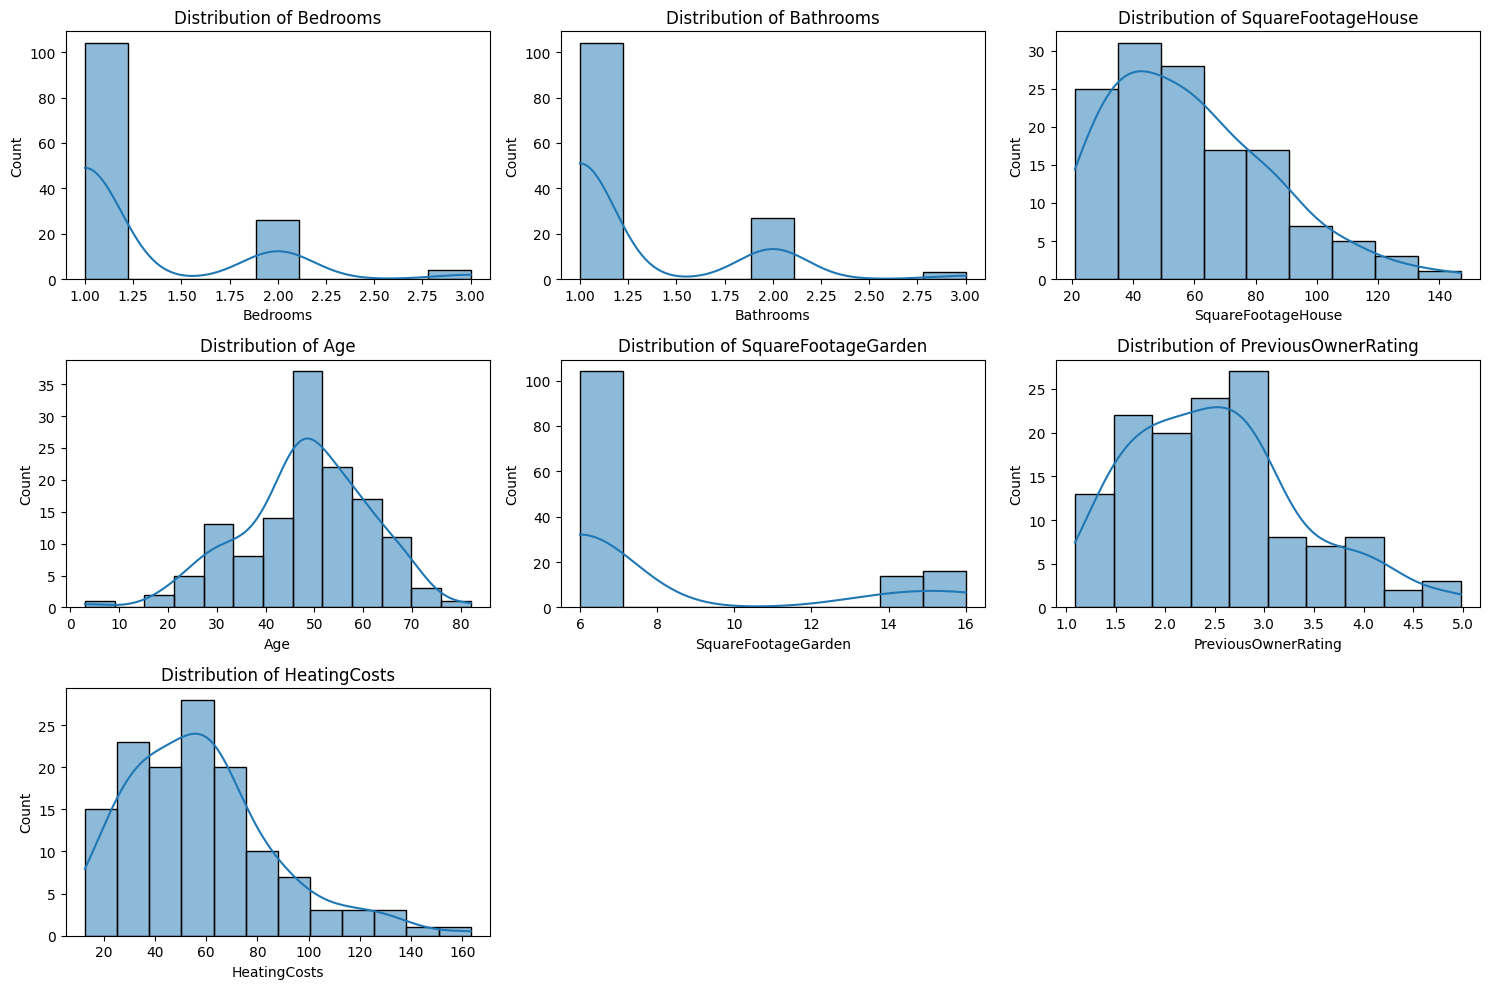

In [27]:
# Plot histograms for numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_budget_houses_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(budget_houses_features[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

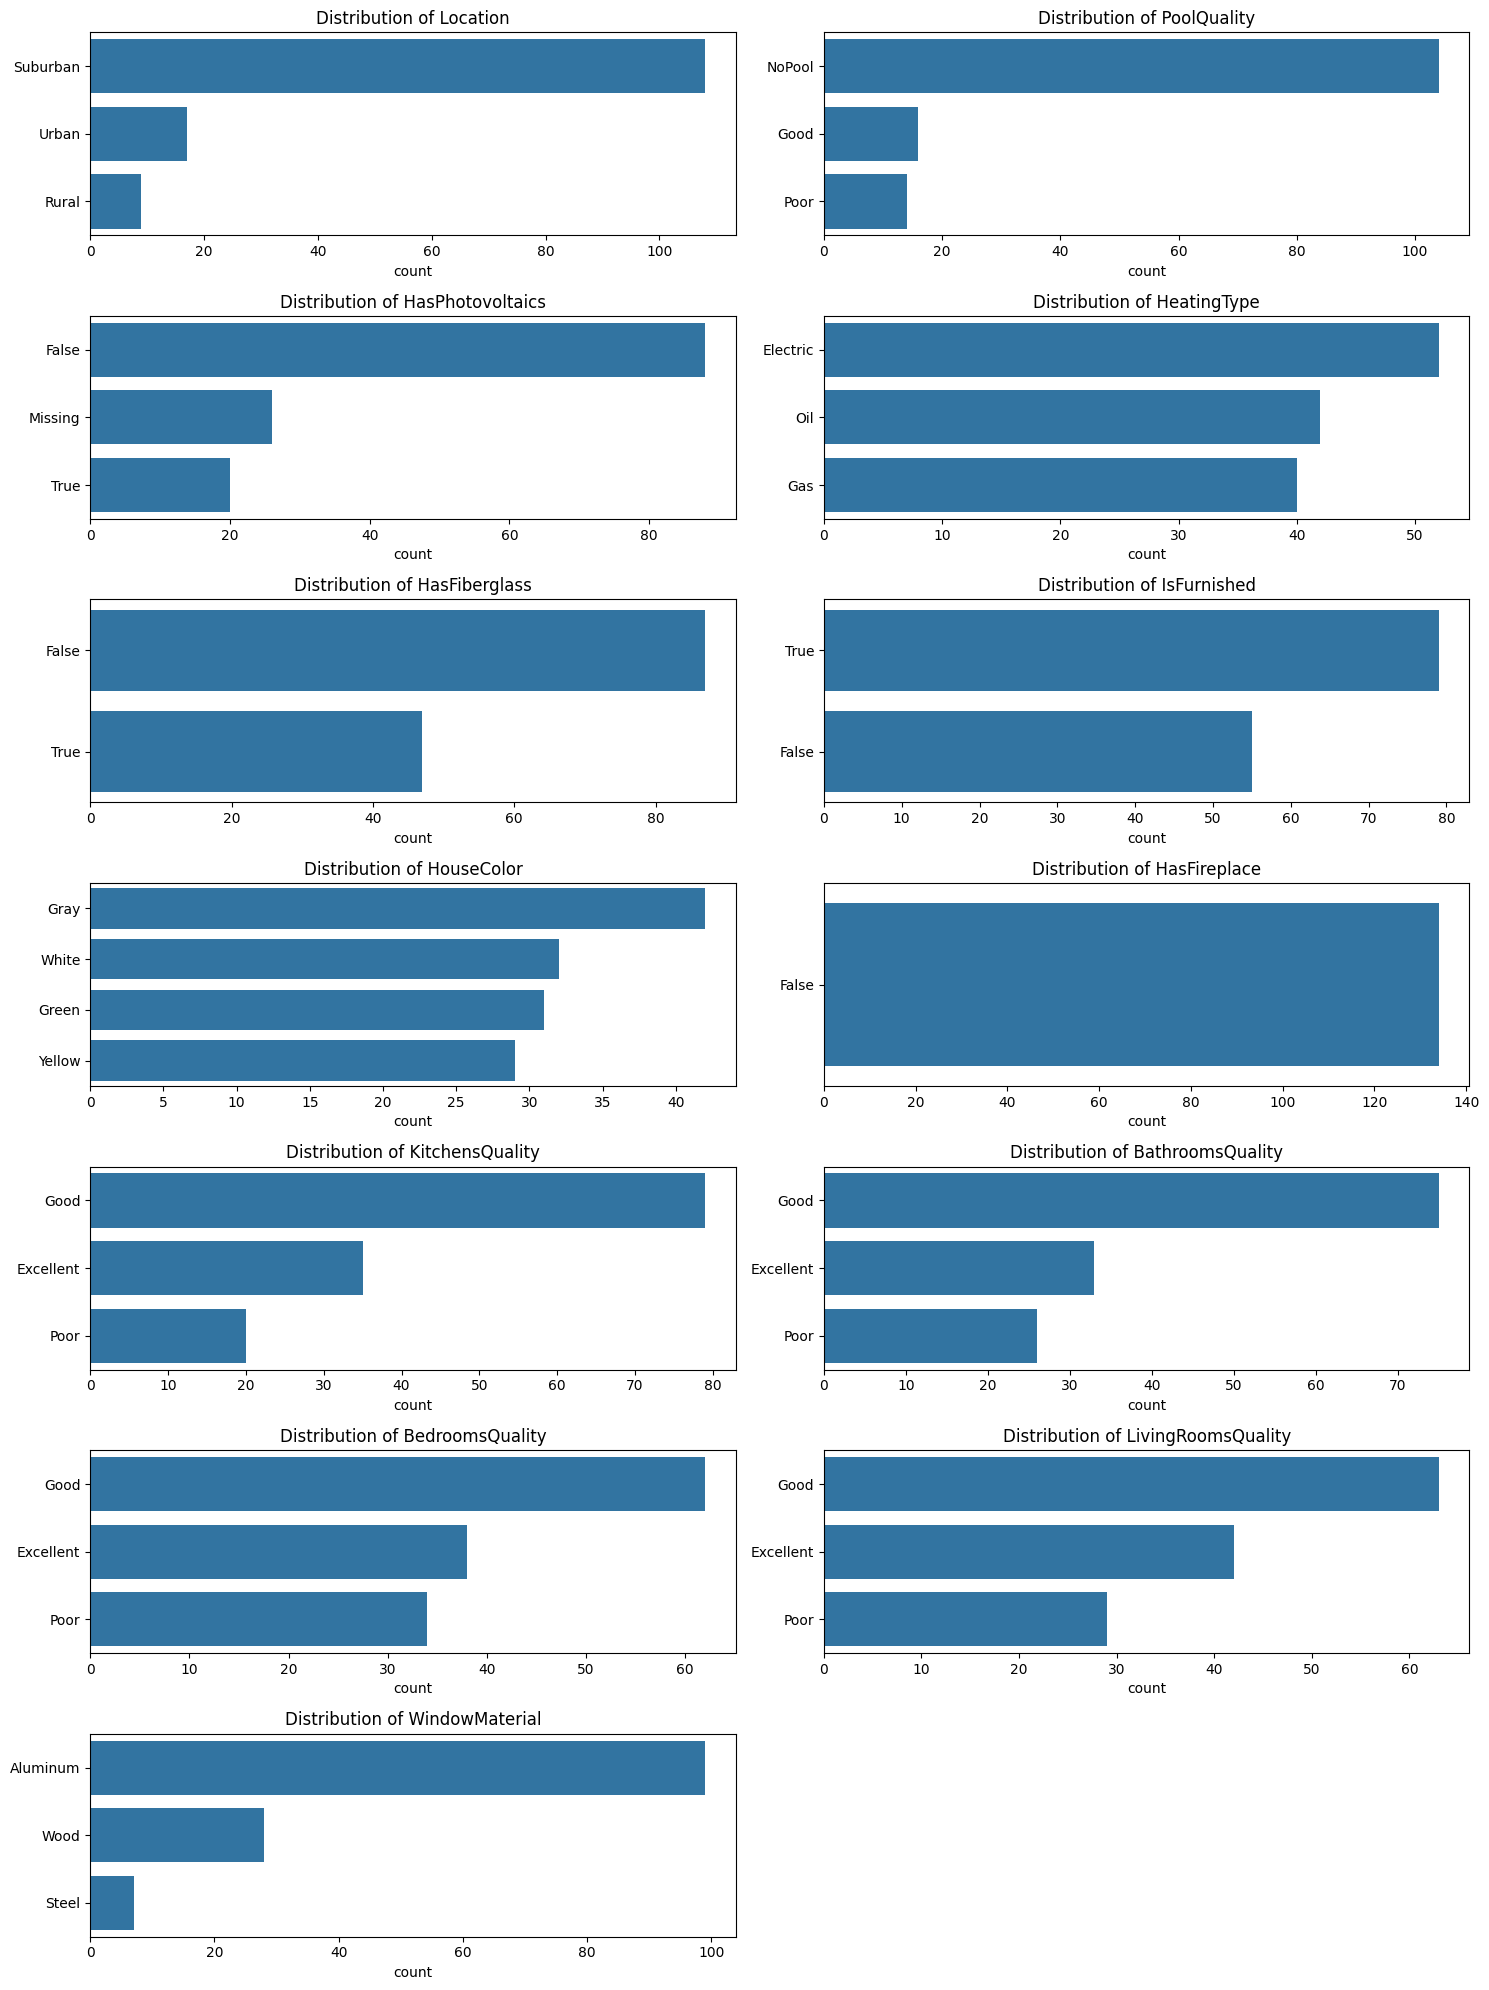

In [29]:
# Plot bar plots for categorical features
plt.figure(figsize=(15, 20))
for i, col in enumerate(categorical_budget_houses_features, 1):
    plt.subplot((len(categorical_budget_houses_features) + 1) // 2, 2, i)
    sns.countplot(y=budget_houses_features[col], order=budget_houses_features[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.ylabel('')
plt.tight_layout()
plt.show()

## Step 4. Briefly describe an average house in this budget 

An average house in this budget of €100,000 would have the following characteristics:

[numerical columns]
- it will most likely have one bedroom and one bathroom
- the house itself would probably have less than 100 sq. meters (and a garden of 6 sq. meters), with slight chances of being larger
- the house could be anywhere between 30 and 70 years old
- chances are the rating of the previous owner will be less than 3.0/5.0
- the heating costs will very likely be below €100 (per month? or per year, have to check that)

[categorical columns]
- the house will highly likely be situated in the suburban area, have no pool, no photovoltaics and for sure no fireplace
- chances are almost equal to have either electric, oil or gas heating, as well as to be furnished or not and to have fiberglass or not
- the quality of the house overall (kitchen, bathrooms, living rooms and bedrooms) will almost certainly be in a good or excellent condition
- the windows will probably be made out of aluminium

# Question 2: 'How much money can I save if I decide not to get a house with a pool?'

## Step 2. Separate the dataset into two groups: houses with a pool and houses without a pool

In [30]:
df['PoolQuality'].unique()

array(['Good', 'Excellent', 'NoPool', 'Poor'], dtype=object)

In [31]:
houses_with_pool = df[df['PoolQuality'] != 'NoPool']
houses_without_pool = df[df['PoolQuality'] == 'NoPool']

## Step 3. Calculate the average predicted price for houses with/without a pool

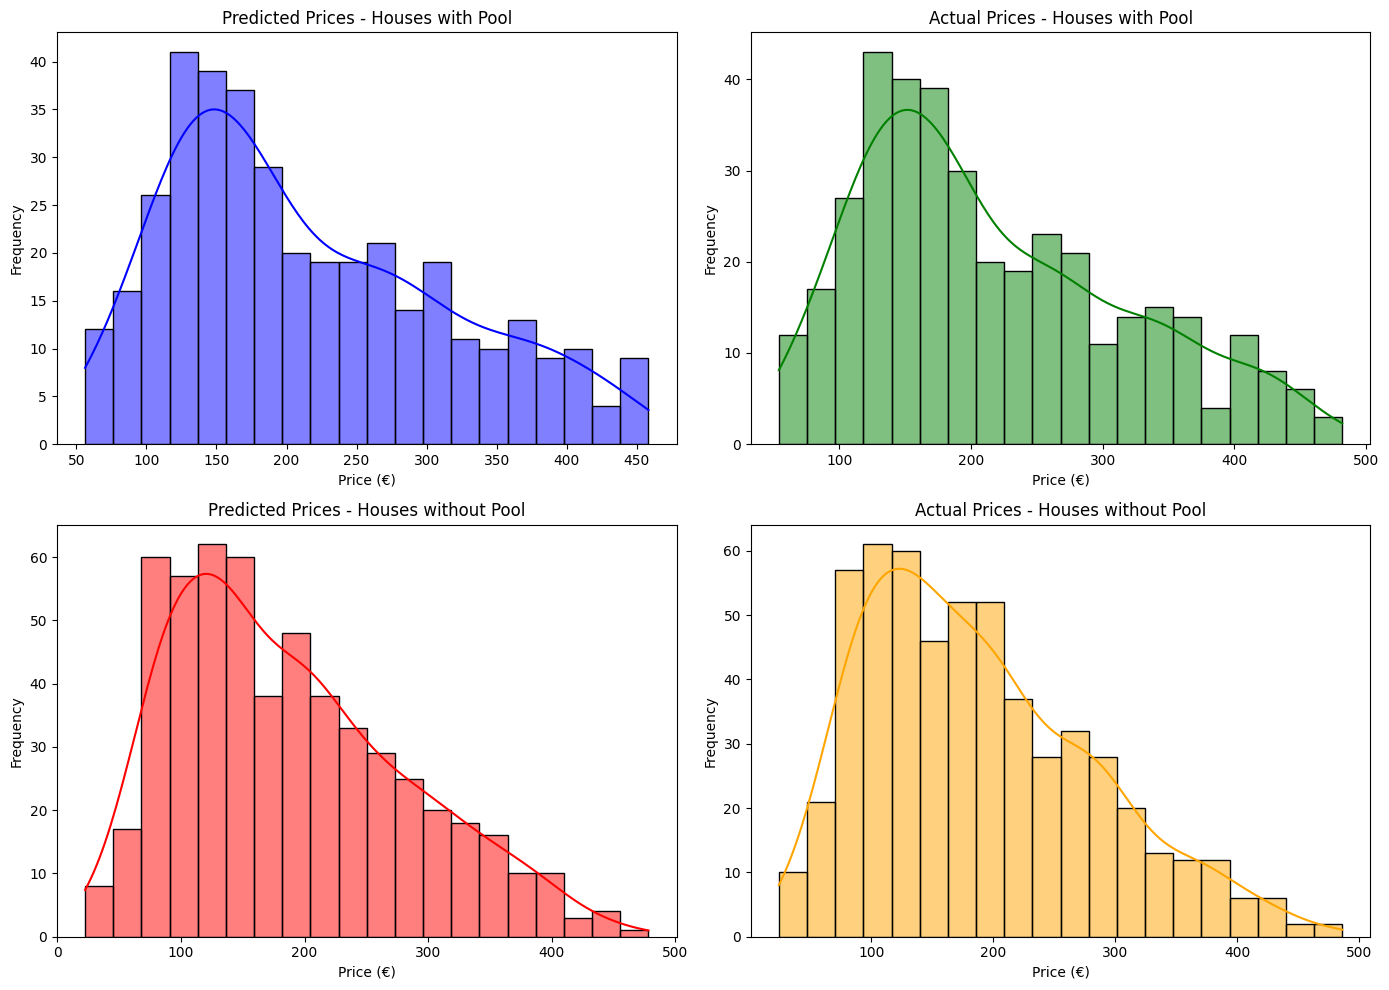

In [44]:
# Plot the histograms side by side
plt.figure(figsize=(14, 10))

# Predicted prices with pool
plt.subplot(2, 2, 1)
sns.histplot(houses_with_pool['Predicted_Price'], kde=True, color='blue', bins=20)
plt.title('Predicted Prices - Houses with Pool')
plt.xlabel('Price (€)')
plt.ylabel('Frequency')

# Actual prices with pool
plt.subplot(2, 2, 2)
sns.histplot(houses_with_pool['Price'], kde=True, color='green', bins=20)
plt.title('Actual Prices - Houses with Pool')
plt.xlabel('Price (€)')
plt.ylabel('Frequency')

# Predicted prices without pool
plt.subplot(2, 2, 3)
sns.histplot(houses_without_pool['Predicted_Price'], kde=True, color='red', bins=20)
plt.title('Predicted Prices - Houses without Pool')
plt.xlabel('Price (€)')
plt.ylabel('Frequency')

# Actual prices without pool
plt.subplot(2, 2, 4)
sns.histplot(houses_without_pool['Price'], kde=True, color='orange', bins=20)
plt.title('Actual Prices - Houses without Pool')
plt.xlabel('Price (€)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [45]:
# Calculate the average predicted and actual prices for houses with a pool
average_predicted_with_pool = houses_with_pool['Predicted_Price'].mean()
average_actual_with_pool = houses_with_pool['Price'].mean()

# Calculate the average predicted and actual prices for houses without a pool
average_predicted_without_pool = houses_without_pool['Predicted_Price'].mean()
average_actual_without_pool = houses_without_pool['Price'].mean()

# Print the averages
print(f"Average predicted price for houses with a pool: €{average_predicted_with_pool * 1000:.2f}")
print(f"Average actual price for houses with a pool: €{average_actual_with_pool * 1000:.2f}")
print(f"Average predicted price for houses without a pool: €{average_predicted_without_pool * 1000:.2f}")
print(f"Average actual price for houses without a pool: €{average_actual_without_pool * 1000:.2f}")

Average predicted price for houses with a pool: €214737.84
Average actual price for houses with a pool: €216290.11
Average predicted price for houses without a pool: €186967.03
Average actual price for houses without a pool: €187888.11


## Step 4. Determine the difference between the average price of houses with a pool and those without a pool

In [50]:
print(f'Average actual difference between prices of houses with and without pool: €{(average_actual_with_pool - average_actual_without_pool) * 1000:.2f}')
print(f'Average predicted difference between prices of houses with and without pool: €{(average_predicted_with_pool - average_predicted_without_pool) * 1000:.2f}')

Average actual difference between prices of houses with and without pool: €28402.00
Average predicted difference between prices of houses with and without pool: €27770.81


On average, based on both the actual and the predicted prices of the houses, one can save around €28000.00 if he decides to buy a house without a pool.

# Discussion: Performance

In [24]:
# rmse
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y, predictions, squared=False)
rmse

/Users/hademohamed/anaconda3/envs/deep-learning/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


12.030948367525184

In [27]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error


mean_regressor = DummyRegressor(strategy="mean")
mean_regressor.fit(X, y)
mean_pred = mean_regressor.predict(X)
mean_mse = mean_squared_error(y, mean_pred, squared=False)
print("Mean Predictor MSE:", mean_mse)


Mean Predictor MSE: 97.32268666920193


/Users/hademohamed/anaconda3/envs/deep-learning/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [33]:
print(f"Performance {(rmse / mean_mse) * 100:.2f}%")

Performance 12.36%
